In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
batchsize=32
imagesize=256
no_classes=15

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=batchsize
)
print(dataset)



Found 20638 files belonging to 15 classes.
Metal device set to: Apple M1
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


2023-03-09 21:49:29.633112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-09 21:49:29.633651: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
#this dataset has now the images as a tensorflow data
#now the len here says how many batches it has and each bach has 32 images len(dataset)*batchsize=totalimages


In [5]:
print(len(dataset))

classname=dataset.class_names
print(len(classname))
print(classname)

645
15
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


2023-03-09 21:49:31.850257: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor(
[[[116. 108. 119.]
  [171. 163. 174.]
  [155. 147. 158.]
  ...
  [105.  95. 104.]
  [103.  93. 102.]
  [105.  95. 104.]]

 [[150. 142. 153.]
  [128. 120. 131.]
  [163. 155. 166.]
  ...
  [110. 100. 109.]
  [ 93.  83.  92.]
  [163. 153. 162.]]

 [[202. 194. 205.]
  [119. 111. 122.]
  [174. 166. 177.]
  ...
  [117. 107. 116.]
  [ 88.  78.  87.]
  [ 90.  80.  89.]]

 ...

 [[148. 137. 141.]
  [132. 121. 125.]
  [149. 138. 142.]
  ...
  [123. 112. 118.]
  [121. 110. 116.]
  [137. 126. 132.]]

 [[129. 118. 122.]
  [159. 148. 152.]
  [122. 111. 115.]
  ...
  [155. 144. 150.]
  [154. 143. 149.]
  [112. 101. 107.]]

 [[190. 179. 183.]
  [108.  97. 101.]
  [105.  94.  98.]
  ...
  [110.  99. 105.]
  [152. 141. 147.]
  [129. 118. 124.]]], shape=(256, 256, 3), dtype=float32)
14
Tomato_healthy


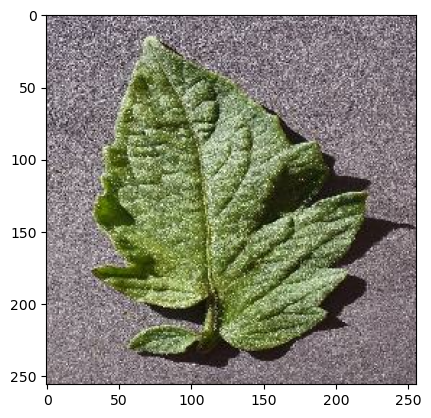

In [6]:
import numpy
i=None
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])
    print(label_batch[0].numpy())
    plt.imshow(image_batch[0].numpy().astype("uint8"))#image shape 32 batch size 256x256 image 3 rgb currently in tensor data will convert it in numpy after wards
   
    print(classname[label_batch[0]])#label of classes
#[[[1 2 3][]][][[]]]

In [7]:
def partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = partition(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [3]:
input__shape = (32, 256, 256, 3)
n_classes = 15

cnn = models.Sequential([
    resize_and_rescale,#data_augmentation
    layers.Conv2D(filters=32, kernel_size = (3,3), activation='relu', input_shape=input__shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

cnn.build(input_shape=input__shape)

NameError: name 'resize_and_rescale' is not defined

In [13]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [14]:
cnn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history = cnn.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10


2023-03-09 21:49:34.238039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


315/516 [=================>............] - ETA: 52s - loss: 2.0057 - accuracy: 0.3483

KeyboardInterrupt: 

In [ ]:
score=cnn.evaluate(test_ds)

In [ ]:
print(score)

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",classname[first_label])
    
    batch_prediction = cnn.predict(images_batch)
    

    print("predicted label:",classname[np.argmax(batch_prediction[0])])
    print("Confidence Level=",max(batch_prediction[0])*100)
    print()
    print(batch_prediction[0])

In [4]:
from keras.models import load_model
model = load_model('2st.h5')
model.summary()

2023-03-10 13:05:26.873697: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-10 13:05:26.874685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)     

In [5]:
import numpy as np
image = tf.keras.utils.load_img(path='testing/1.jpg',target_size=(256,256))
input_arr = tf.keras.utils.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.


In [6]:
input_arr[0]

array([[[204., 198., 210.],
        [207., 201., 213.],
        [209., 203., 215.],
        ...,
        [110.,  98., 112.],
        [100.,  88., 102.],
        [116., 104., 118.]],

       [[182., 176., 188.],
        [193., 187., 199.],
        [177., 171., 183.],
        ...,
        [ 93.,  81.,  95.],
        [124., 112., 126.],
        [159., 147., 161.]],

       [[191., 185., 197.],
        [192., 186., 198.],
        [195., 189., 201.],
        ...,
        [172., 160., 174.],
        [133., 121., 135.],
        [180., 168., 182.]],

       ...,

       [[118., 105., 115.],
        [123., 110., 120.],
        [144., 131., 141.],
        ...,
        [130., 114., 124.],
        [124., 108., 118.],
        [109.,  93., 103.]],

       [[148., 135., 145.],
        [147., 134., 144.],
        [148., 135., 145.],
        ...,
        [123., 107., 117.],
        [112.,  96., 106.],
        [108.,  92., 102.]],

       [[134., 121., 131.],
        [145., 132., 142.],
        [150., 1

In [7]:
output=model.predict(input_arr)
print(output)

classname=['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

1/1 [==============================] - 0s 158ms/step
[[3.66050813e-06 4.66449506e-04 4.51713536e-12 1.24246098e-08
  1.85100146e-06 3.63630970e-09 1.20737255e-04 2.03664422e-06
  1.12217705e-07 3.76534990e-05 2.36845179e-03 9.46679592e-01
  1.55050337e-08 1.06198972e-09 5.03194220e-02]]


2023-03-10 13:05:38.968738: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-10 13:05:39.031218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


predicted label: Tomato__Target_Spot


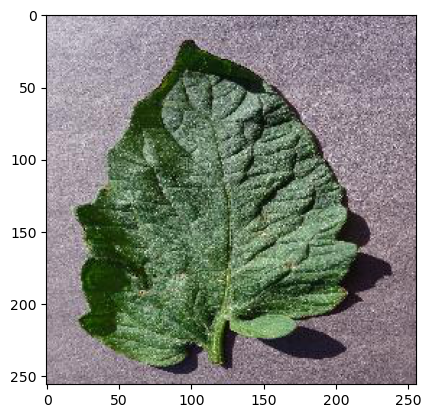

In [8]:
print("predicted label:",classname[np.argmax(output[0])])
plt.imshow(input_arr[0].astype("uint8"))